# Processing Language in Texts

In R, the best library to deal with textual information is using the `tm` library. You can find additional information about this package at `http://tm.r-forge.r-project.org/`.

In [5]:
if (!("tm" %in% rownames(installed.packages()))) {
    install.packages("tm", repos='http://cran.us.r-project.org')
}

## Defining understanding as tokenization

In [6]:
library(tm)
texts = c("My dog gets along with cats", 
         "That cat is vicious",
         "My dog is happy when it is lunch")

Loading required package: NLP



## Putting all the documents into a bag

### Obtaining the vocabulary size

In [7]:
strsplit_space_tokenizer <- function(x)
    unlist(strsplit(as.character(x), "[[:space:]]+"))

unique_words <- unique(strsplit_space_tokenizer(texts))
print(paste("There are", length(unique_words), "unique words"))

[1] "There are 14 unique words"


### Processing the text

In [8]:
for (text in texts) {
    print(strsplit_space_tokenizer(text))
}

[1] "My"    "dog"   "gets"  "along" "with"  "cats" 
[1] "That"    "cat"     "is"      "vicious"
[1] "My"    "dog"   "is"    "happy" "when"  "it"    "is"    "lunch"


In [9]:
corpus <- VCorpus(VectorSource(texts)) 
dtm <- DocumentTermMatrix(corpus)

In [10]:
inspect(dtm)

<<DocumentTermMatrix (documents: 3, terms: 11)>>
Non-/sparse entries: 12/21
Sparsity           : 64%
Maximal term length: 7
Weighting          : term frequency (tf)
Sample             :
    Terms
Docs along cat cats dog gets happy lunch that vicious when
   1     1   0    1   1    1     0     0    0       0    0
   2     0   1    0   0    0     0     0    1       1    0
   3     0   0    0   1    0     1     1    0       0    1


### Using the TF-IDF transformation instead

In [11]:
dtm <- DocumentTermMatrix(corpus,
           control = list(weighting = function(x) weightTfIdf(x, normalize=TRUE)))

In [12]:
inspect(dtm)

<<DocumentTermMatrix (documents: 3, terms: 11)>>
Non-/sparse entries: 12/21
Sparsity           : 64%
Maximal term length: 7
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)
Sample             :
    Terms
Docs     along       cat      cats      gets     happy     lunch      that
   1 0.3169925 0.0000000 0.3169925 0.3169925 0.0000000 0.0000000 0.0000000
   2 0.0000000 0.5283208 0.0000000 0.0000000 0.0000000 0.0000000 0.5283208
   3 0.0000000 0.0000000 0.0000000 0.0000000 0.3962406 0.3962406 0.0000000
    Terms
Docs   vicious      when      with
   1 0.0000000 0.0000000 0.3169925
   2 0.5283208 0.0000000 0.0000000
   3 0.0000000 0.3962406 0.0000000


### Retaining order using RNNs

The `text_tokenizer` (see `https://keras.rstudio.com/reference/text_tokenizer.html`) is a function that will turn your text into a sequence of indexes that a neural network can read (with a few more processing steps). You must have RTools (`https://cran.r-project.org/bin/windows/Rtools/`) to perform these next steps. In addition, the process can take a while to run, so you need to be patient.

In [13]:
if (!("keras" %in% rownames(installed.packages()))) {
    install.packages("devtools", repos='http://cran.us.r-project.org')
    devtools::install_github("rstudio/keras")
    reticulate::py_config()
}

library(keras)

In [14]:
tokenizer <- text_tokenizer(num_words=length(unique_words))
fit_text_tokenizer(tokenizer, texts)
sequences <- texts_to_sequences(tokenizer, texts)

print(sequences)

[[1]]
[1] 2 3 4 5 6 7

[[2]]
[1]  8  9  1 10

[[3]]
[1]  2  3  1 11 12 13  1



In particular, another Keras function, `to_categorical` (`https://keras.rstudio.com/reference/to_categorical.html`) converts the sequences by one hot encoding, creating a set of indicators for each one.

In [15]:
print(to_categorical(unlist(sequences[1])))

     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    0    0    1    0    0    0    0    0
[2,]    0    0    0    1    0    0    0    0
[3,]    0    0    0    0    1    0    0    0
[4,]    0    0    0    0    0    1    0    0
[5,]    0    0    0    0    0    0    1    0
[6,]    0    0    0    0    0    0    0    1


## Using AI for Sentiment Analysis

### Getting the IMDb data

In [16]:
if (!("keras" %in% rownames(installed.packages()))) {
    install.packages("devtools")
    devtools::install_github("rstudio/keras", repos='http://cran.us.r-project.org')
    reticulate::py_config()
}

library(keras)

In [17]:
top_words <- 10000
imdb <- dataset_imdb(num_words = top_words)

x_train <- imdb$train$x
y_train <- imdb$train$y
x_test  <- imdb$test$x
y_test  <- imdb$test$y

In [18]:
print(paste("Training examples:", length(x_train)))
print(paste("Test examples:", length(x_test)))

[1] "Training examples: 25000"
[1] "Test examples: 25000"


In [19]:
summary(as.factor(y_train))

0     1 
12500 12500

### Creating the review dictionaries

In [20]:
word_index <- dataset_imdb_word_index()

id_to_word <- data.frame(
  word = names(word_index),
  idx = unlist(word_index, use.names=FALSE),
  stringsAsFactors = FALSE
)

id_to_word$idx <- id_to_word$idx + 3
id_to_word[nrow(id_to_word) + 1,] = c("<PAD>", 0)
id_to_word[nrow(id_to_word) + 1,] = c("<START>", 1)
id_to_word[nrow(id_to_word) + 1,] = c("<UNK>", 2)
id_to_word[nrow(id_to_word) + 1,] = c("<UNUSED>", 3)

convert_to_text <- function(sequence) {
    text = ""
    for (element in sequence) {
        text <- paste(text, id_to_word$word[which(id_to_word$idx == element)])
    }
    return (text)
}

In [21]:
print(convert_to_text(x_train[[1]]))

[1] " <START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised f

### Performing input padding

In [22]:
max_pad <- 200

x_train <- pad_sequences(
  x_train,
  value = 0,
  padding = "post",
  maxlen = max_pad
)

x_test <- pad_sequences(
  x_test,
  value = 0,
  padding = "post",
  maxlen = max_pad
)

### Designing an architecture

In [23]:
embedding_vector_length <- 32

model <- keras_model_sequential()
model %>% 
  layer_embedding(input_dim=top_words, 
                  output_dim=embedding_vector_length) %>%
  layer_global_average_pooling_1d() %>%
  layer_dense(units = 16, activation = "relu") %>%
  layer_dense(units = 1, activation = "sigmoid")

model

Model: "sequential"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 embedding (Embedding)              (None, None, 32)                320000      
 global_average_pooling1d (GlobalAv  (None, 32)                     0           
 eragePooling1D)                                                                
 dense_4 (Dense)                    (None, 16)                      528         
 dense_3 (Dense)                    (None, 1)                       17          
Total params: 320,545
Trainable params: 320,545
Non-trainable params: 0
________________________________________________________________________________

In [24]:
model %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy',
  metrics = list('accuracy')
)

### Training and testing the network

In [25]:
history <- model %>% fit(
  x_train,
  y_train,
  epochs = 15,
  batch_size = 256,
  validation_data = list(x_test, y_test),
  verbose=1
)

Test loss: 0.3443515 
Test accuracy: 0.868 


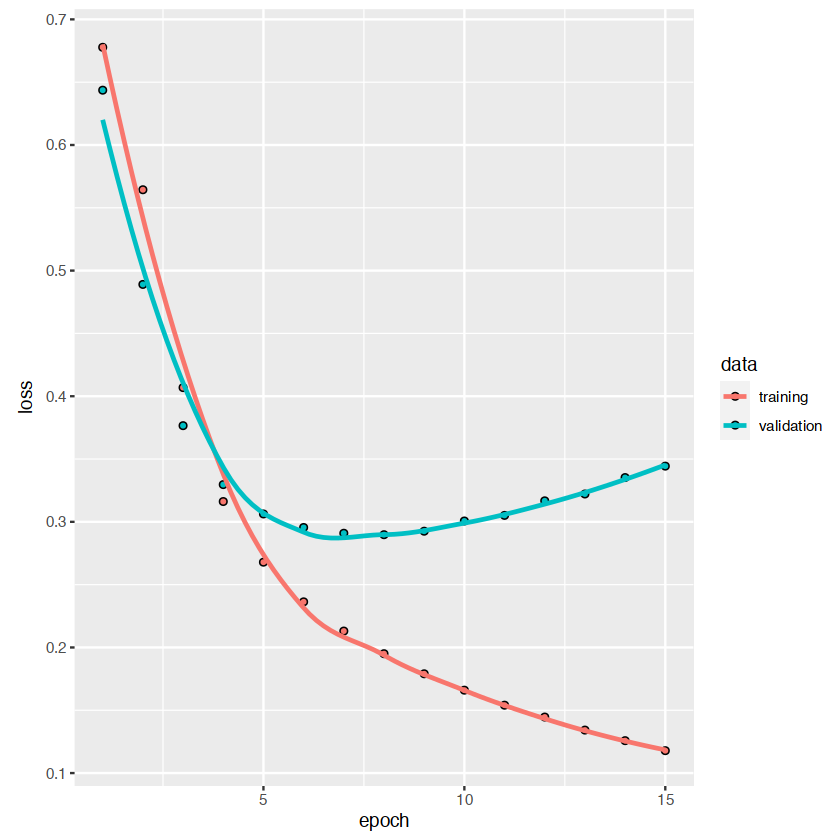

In [26]:
# Plotting training and test dynamics
plot(history, method='auto', metrics=c('loss', 'binary_crossentropy'))

# Output metrics
scores <- model %>% evaluate(x_test, y_test, verbose=0)
cat('Test loss:', scores[[1]], '\n')
cat('Test accuracy:', scores[[2]], '\n')

# Processing Time Series

## Defining sequences of events

In [27]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
x = read.csv(file=url)
x[,1] <- as.Date(paste(x[,1],"-01",sep=""))

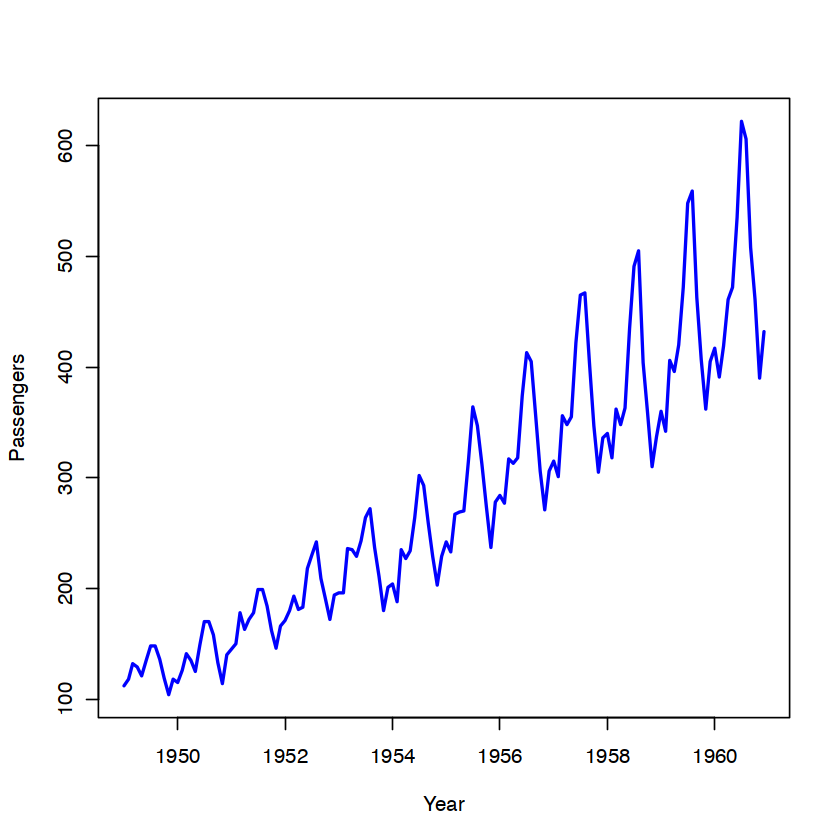

In [28]:
plot(x$Passengers~x$Month, 
     type='l', lwd=2, col="blue", 
     xlab="Year", ylab="Passengers")

## Performing a prediction using LSTM

### Creating training and testing datasets

In [29]:
normValues <- (x$Passengers - min(x$Passengers)) / (max(x$Passengers) - min(x$Passengers))
train <- normValues[1:96]
test <- normValues[96:144]
print(paste("Train size:", length(train), ", Test size:", length(test)))

[1] "Train size: 96 , Test size: 49"


In [30]:
create_dataset <- function(data, lookback) {
    batch <- list()
    response <- list()
    for (t in (lookback+1):(length(data)-1)) {
        iteration <- length(batch)+1
        batch[[iteration]] <- data[(t-lookback):t]
        response[[iteration]] <- data[t+1]
    }
    return(list(array(unlist(batch), dim=c(length(batch), 1, lookback+1)) , unlist(response)))
}

In [31]:
train_extract <- create_dataset(train, lookback=1)
test_extract <- create_dataset(test, lookback=1)
trainX <- train_extract[[1]]
trainY <- train_extract[[2]]
testX <- test_extract[[1]]
testY <- test_extract[[2]]

### Defining the passenger analysis model

In [33]:
library(keras)

model <- keras_model_sequential() %>% 
  layer_gru(units = 1, input_shape = c(NULL, dim(trainX)[2], dim(trainX)[3])) %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_adam(),
  loss = "mean_squared_error"
)

history <- model %>% fit(
    trainX,
    trainY,
    epochs = 50,
    batch_size = 1,
    validation_data = list(testX, testY),
    verbose=1
)

c(NULL, dim(trainX)[2], dim(trainX)[3])

[1] 1 2

In [39]:
normValues

[1] 0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
  [7] 0.08494208 0.08494208 0.06177606 0.02895753 0.00000000 0.02702703
 [13] 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 [19] 0.12741313 0.12741313 0.10424710 0.05598456 0.01930502 0.06949807
 [25] 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 [31] 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 [37] 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 [43] 0.24324324 0.26640927 0.20270270 0.16795367 0.13127413 0.17374517
 [49] 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 [55] 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 [61] 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 [67] 0.38223938 0.36486486 0.29922780 0.24131274 0.19111969 0.24131274
 [73] 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 [79] 0.50193050 0.46911197 0.40154440 0.32818533 0.25675676 0.33590734
 [85] 0.34749035 0.33397683 0.41119691 0.40347490 0.41312741 0.52123552
 [91] 0.59652510 0.58108108 0.48455598 0.38996139 0.32239382 0.38996139
 [97] 0.40733591 0.38030888 0.48648649 0.47104247 0.48455598 0.61389961
[103] 0.69691120 0.70077220 0.57915058 0.46911197 0.38803089 0.44787645
[109] 0.45559846 0.41312741 0.49806950 0.47104247 0.50000000 0.63899614
[115] 0.74710425 0.77413127 0.57915058 0.49227799 0.39768340 0.44980695
[121] 0.49420849 0.45945946 0.58301158 0.56370656 0.61003861 0.71042471
[127] 0.85714286 0.87837838 0.69305019 0.58494208 0.49806950 0.58108108
[133] 0.60424710 0.55405405 0.60810811 0.68918919 0.71042471 0.83204633
[139] 1.00000000 0.96911197 0.77992278 0.68918919 0.55212355 0.63320463

### Making a prediction

Test mean_squared_error: 0.01977898 


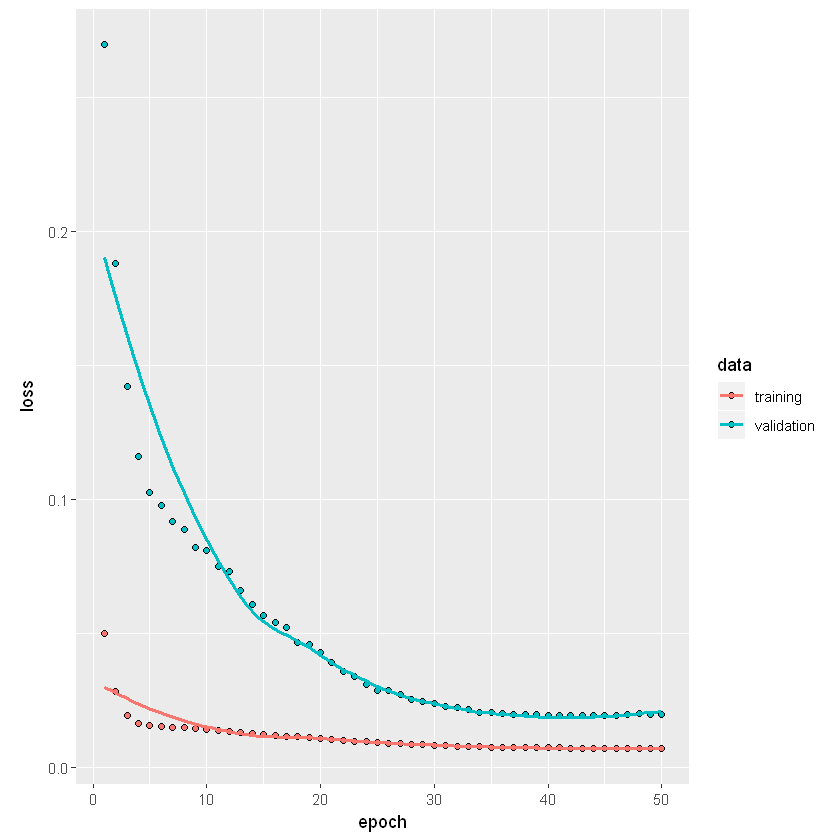

In [188]:
# Plotting training and test dynamics
plot(history, method='auto', metrics=c('loss', 'mean_squared_error'))

# Output metrics
scores <- model %>% evaluate(testX, testY, verbose=0)
cat('Test RMSE:', scores[[1]], '\n')